## Question Number 2

The question:
> Can you build a Machine Learning model (not Artificial Neural Network) to categorize the alcohol molecule given readings from the electronic nose? (Please consider the MIP: NP ratio as one of the features as well) Please justify your choice of algorithm and walk us through your logic as you develop the model. What is the accuracy, precision, and recall of the model?

So in this notebook we will answer the above question, we will also consider using MIP/NP ratio as one of the features for our models. I will train 3 machine leearning models in this notebook which is Logistic Regression, Random Forest, and Gradient Boosting.

## Importing modules

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.datasets import make_classification
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression

## Loading Datasets

In [2]:
qcm3_df = pd.read_csv('./dataset/QCM3.csv', delimiter=';')
qcm6_df = pd.read_csv('./dataset/QCM6.csv', delimiter=';')
qcm7_df = pd.read_csv('./dataset/QCM7.csv', delimiter=';')
qcm10_df = pd.read_csv('./dataset/QCM10.csv', delimiter=';')
qcm12_df = pd.read_csv('./dataset/QCM12.csv', delimiter=';')

DFs = {
    'QCM3': qcm3_df,
    'QCM6': qcm6_df,
    'QCM7': qcm7_df,
    'QCM10': qcm10_df,
    'QCM12': qcm12_df,
}

## Collapsing dataframe

In [3]:
def collapse_df(df: pd.DataFrame) -> pd.DataFrame:
    new_data = {
        'MIP': [],
        'NP': [],
        'ratio': []
    }
    for alcohol in df.columns[-5:]:
        new_data[alcohol] = []

    for l in range(5):
        df_l = df.loc[df[df.columns[-5+l]] == 1]
        np_l = df_l.to_numpy()
        for c in range(5):
            new_data['MIP'].extend(np_l[:, 2*c].tolist())
            new_data['NP'].extend(np_l[:, 2*c+1].tolist())
            new_data['ratio'].extend((np_l[:, 2*c]/np_l[:, 2*c+1]).tolist())

            alc_i = -5
            for alcohol in df.columns[-5:]:
                new_data[alcohol].extend(np_l[:, alc_i].tolist())
                alc_i += 1
    new_df = pd.DataFrame(new_data)
    return new_df


I assume that we want our models to be able to determine the kind of alcohol irrespective of its concentration. Hence, the datasets need to be collapsed so we only have one column for MIP sensor readings and also one column for NP sensor readings.

In [4]:
DFs['QCM3'].loc[:1, :]

,0.799_0.201_MIP,0.799_0.201_NP,0.700_0.300_MIP,0.700_0.300_NP,0.600_0.400_MIP,0.600_0.400_NP,0.501_0.499_MIP,0.501_0.499_NP,0.400_0.600_MIP,0.400_0.600_NP,1-Octanol,1-Propanol,2-Butanol,2-propanol,1-isobutanol
0,-10.06,-10.62,-14.43,-18.31,-24.64,-30.56,-38.62,-45.59,-54.89,-62.28,1,0,0,0,0
1,-9.69,-10.86,-16.73,-21.75,-28.47,-35.83,-43.65,-52.43,-61.92,-71.27,1,0,0,0,0


In [5]:
collapse_df(DFs['QCM3'].loc[:1, :])

,MIP,NP,ratio,1-Octanol,1-Propanol,2-Butanol,2-propanol,1-isobutanol
0,-10.06,-10.62,0.947269,1.0,0.0,0.0,0.0,0.0
1,-9.69,-10.86,0.892265,1.0,0.0,0.0,0.0,0.0
2,-14.43,-18.31,0.788094,1.0,0.0,0.0,0.0,0.0
3,-16.73,-21.75,0.769195,1.0,0.0,0.0,0.0,0.0
4,-24.64,-30.56,0.806283,1.0,0.0,0.0,0.0,0.0
5,-28.47,-35.83,0.794586,1.0,0.0,0.0,0.0,0.0
6,-38.62,-45.59,0.847116,1.0,0.0,0.0,0.0,0.0
7,-43.65,-52.43,0.832539,1.0,0.0,0.0,0.0,0.0
8,-54.89,-62.28,0.881342,1.0,0.0,0.0,0.0,0.0
9,-61.92,-71.27,0.868809,1.0,0.0,0.0,0.0,0.0


Above is the example of the result of `collapse_df` functions, along with collapsing MIP and NP columns we also calculate the ratio of MIP/NP which could be useful as additional feature for our models.

## Train/Test Split

In [6]:
def test_train_split(df: pd.DataFrame, test_frac: float=.4, labels_start_index: int=-5):
    N_total = df.shape[0]
    test_indexes = []
    for c in range(abs(labels_start_index)):
        # proportion = df[df[df.columns[-5]] == 1].shape[0]/N_total
        test_indexes.extend(
                df[df[df.columns[labels_start_index+c]] == 1]
                .sample(frac=test_frac).index.to_list()
            )
    train_df = df.drop(index=test_indexes)
    test_df = df.iloc[test_indexes]
    
    return train_df, test_df
    

Since the datasets that we have are as balanced as it can be (5 categories with 20% proportion for each category). We need a way to keep those proportions when we split the datasets to train and test data. The functions above made sure that each category keeps its 20% proportion even after being split into train and test.

In [7]:
def get_proportions(df: pd.DataFrame):
    N_total = df.shape[0]
    for c in df.columns[-5:]:
        c_count = df.loc[df[c] == 1].shape[0]
        percentage = 100 * c_count/N_total
        print (f"  {c}\t: {percentage:4.1f}% ({c_count}/{N_total})")


_train, _test = test_train_split(collapse_df(DFs['QCM3']))

print("Proportion of train data")
get_proportions(_train)

print("\nProportion of train data")
get_proportions(_test)

Proportion of train data
  1-Octanol	: 20.0% (15/75)
  1-Propanol	: 20.0% (15/75)
  2-Butanol	: 20.0% (15/75)
  2-propanol	: 20.0% (15/75)
  1-isobutanol	: 20.0% (15/75)

Proportion of train data
  1-Octanol	: 20.0% (10/50)
  1-Propanol	: 20.0% (10/50)
  2-Butanol	: 20.0% (10/50)
  2-propanol	: 20.0% (10/50)
  1-isobutanol	: 20.0% (10/50)


As can be seen above, the proportion is consistent even after train/test split.

## Training

Below is the function that will process our data from the beginning, doing the train-test split, training the model, and finally calculating the metrics on test data.

For features, by default MIP and NP readings will be included. I added option to include `ratio` (MIP/NP) as additional feature so we can compare it later. The fractional split for test and train data is 60% training data and 40% test data, I choose that ratio because for our data that is multiples of 5, 60% to 40% split nicely into 3/5 and 2/5 of the training data.

The train-test split is randomize so each runs might produce different metrics, hence why we will run this process for each models (and features) configurations several times and then average the results for comparison.

In [8]:
def one_hot(x, num_categories=5):
    one_hot_matrix = np.eye(num_categories)
    one_hot_encoded_data = one_hot_matrix[x.ravel()]
    return one_hot_encoded_data

def train(model, df: pd.DataFrame, include_ratio: bool=True, average="macro", use_integer_label=False): 
    train_df, test_df = test_train_split(collapse_df(df))
    
    feature_split_index = 3 if include_ratio else 2
    X_train = train_df.to_numpy()[:, :feature_split_index]
    y_train = train_df.to_numpy()[:, -5:]

    X_test = test_df.to_numpy()[:, :feature_split_index]
    y_test = test_df.to_numpy()[:, -5:]

    if (use_integer_label):
        y_train = np.argmax(y_train, axis=1)
        y_test = np.argmax(y_test, axis=1)

    scaler = MinMaxScaler()
    scaler.fit(X_train)

    print('begin training')
    model.fit(scaler.transform(X_train), y_train)
    
    train_pred = model.predict(scaler.transform(X_train))
    if (use_integer_label):
        yt_oh = one_hot(y_train, num_categories=5)
        pred_oh = one_hot(train_pred, num_categories=5)
        print(f'train acc       -> {100*accuracy_score(yt_oh, pred_oh):5.3f}%')
        print(f'train precision -> {100*precision_score(yt_oh, pred_oh, average=average):5.3f}%')
        print(f'train recall    -> {100*recall_score(yt_oh, pred_oh, average=average):5.3f}%')
    else:
        print(f'train acc       -> {100*accuracy_score(y_train, train_pred):5.3f}%')
        print(f'train precision -> {100*precision_score(y_train, train_pred, average=average):5.3f}%')
        print(f'train recall    -> {100*recall_score(y_train, train_pred, average=average):5.3f}%')

    print('\nbegin testing')
    metrics = {}
    y_pred = model.predict(scaler.transform(X_test))
    if (use_integer_label):
        yt_oh = one_hot(y_test, num_categories=5)
        pred_oh = one_hot(y_pred, num_categories=5)
        metrics['accuracy'] = accuracy_score(yt_oh, pred_oh)
        metrics['precision'] = precision_score(yt_oh, pred_oh, average=average)
        metrics['recall'] = recall_score(yt_oh, pred_oh, average=average)
    else:
        metrics['accuracy'] = accuracy_score(y_test, y_pred)
        metrics['precision'] = precision_score(y_test, y_pred, average=average)
        metrics['recall'] = recall_score(y_test, y_pred, average=average)
    
    print('finished training session')
    return metrics, X_train, y_train, X_test, y_test



Here is the function that will called the previous `train` functions several times as specified by `trial_counts` parameter. Keep in mind that this function only runs for one model and one datasets (we have 5 different QCM readings). As said previously, the resulting metrics then averaged so we can get more consistent value.

The choice of 21 for `trial_counts` is arbitrary as I see at that number the results became quite consistent.

In [9]:
def train_model(model_builder, df: pd.DataFrame, 
        trial_counts:int=21, include_ratio=True, use_integer_label=False):
    metrics = {
        'accuracy': [],
        'precision': [],
        'recall': []
    }

    for i in range(trial_counts):
        print(f"Begin itteration {i+1}")
        model = model_builder()
        _metrics, _, _, _, _ = train(model, df, average='macro', 
                    use_integer_label=use_integer_label,
                    include_ratio=include_ratio
                    )

        print(f"metrics trials {i+1}: {_metrics}\n")

        metrics['accuracy'].append(_metrics['accuracy'])
        metrics['precision'].append(_metrics['precision'])
        metrics['recall'].append(_metrics['recall'])

    for key in metrics.keys():
        metrics[key] = np.mean(metrics[key])

    print(f'\nAverage metrics for {trial_counts} trials:\n\t{metrics}')
    return metrics

And finally this is the function that will run all 5 datasets to one model, here I'm using `model_builder` function to create the model before every trials. 

In [10]:
def get_metrics_for_model(
        model_builder, include_ratio=True, use_integer_label=False):
    metrics = {
        'sensor': [],
        'accuracy': [],
        'precision': [],
        'recall': []
    }
    for key in DFs.keys():
        _metrics = train_model(
            model_builder, DFs[key], include_ratio=include_ratio, 
            use_integer_label=use_integer_label
            )
        metrics['sensor'].append(key)
        for mKey in _metrics.keys():
            metrics[mKey].append(_metrics[mKey])

    print("Everything is finished")
    return metrics

The functions below are just utility functions to show and visualize resulting metrics gathered from training process.

In [11]:
def plot_metrics(metrics, model_name: str=''):
    width = 0.25

    ind = np.arange(len(metrics['sensor']))

    figs = []
    metric_names = list(metrics.keys())[1:]
    for i, m in enumerate(metric_names):
        
        fig = plt.bar(ind+i*width, metrics[m], width, edgecolor='black')
        figs.append(fig)

    plt.legend(figs, metric_names, loc='lower right')

    plt.xticks(ind+width, metrics['sensor'])
    plt.xlabel('Sensor Type')
    plt.ylabel('Accuracy (%)')

    plt.ylim(0, 1)
    plt.title(', '.join(['Accuracy for each sensors', model_name]))

    plt.grid()
    plt.show()

def plot_metrics_comp(packed_metrics: list, model_name: str=''):
    width = 0.25

    metrics_w, metrics_wo = packed_metrics
    ind = np.arange(len(metrics_w['sensor']))

    color_dict = {
        'accuracy': 'red',
        'precision': 'black',
        'recall': 'grey',
    }
    figs = []
    metric_names = list(metrics_w.keys())[1:]
    for i, m in enumerate(metric_names):
        
        fig = plt.bar(ind+i*width, metrics_w[m], width/2, color=color_dict[m], edgecolor='black')
        fig = plt.bar(ind+i*width+width/2, metrics_wo[m], width/2, color=color_dict[m], edgecolor='black')
        figs.append(fig)

    plt.legend(figs, metric_names, loc='lower right')

    plt.xticks(ind+width, metrics_w['sensor'])
    plt.xlabel('Sensor Type')
    plt.ylabel('Accuracy (%)')

    plt.ylim(0, 1)
    plt.title(', '.join(['Accuracy for each sensors', model_name]))

    plt.grid()
    plt.show()

In [12]:
def show_model_metrics(packed_metrics: list):
    metrics_w_ratio, metrics_wo_ratio = packed_metrics
    metrics_df = pd.DataFrame(metrics_w_ratio)
    metrics_df = pd.concat([metrics_df, pd.DataFrame(metrics_wo_ratio).drop(columns=['sensor'])], axis=1)

    with_ratio_col = 'With MIP/NP Ratio'
    without_ratio_col = 'Without MIP/NP Ratio'
    metrics_df.columns = pd.MultiIndex.from_tuples(
        [
            ('sensor', 'type'),
            (with_ratio_col, 'accuracy'),
            (with_ratio_col, 'precision'),
            (with_ratio_col, 'recall'),
            (without_ratio_col, 'accuracy'),
            (without_ratio_col, 'precision'),
            (without_ratio_col, 'recall'),
        ]
    )

    display(metrics_df)

## Logistic Regression

The first model to train is Logistic Regression, this model is very popular and has many use cases. It is also one of the most robust and well studied algorithm out there. That's why we will include this model and use it as a baseline.

In [13]:
def lg_builder():
    return LogisticRegression(max_iter=1000, multi_class='multinomial')


metrics_w_ratio = get_metrics_for_model(
    lg_builder, include_ratio=True, use_integer_label=True)
metrics_wo_ratio = get_metrics_for_model(
    lg_builder, include_ratio=False, use_integer_label=True)
lg_metrics = [metrics_w_ratio, metrics_wo_ratio]

Begin itteration 1
begin training
train acc       -> 72.000%
train precision -> 78.882%
train recall    -> 72.000%

begin testing
finished training session
metrics trials 1: {'accuracy': 0.48, 'precision': 0.527485380116959, 'recall': 0.4800000000000001}

Begin itteration 2
begin training
train acc       -> 72.000%
train precision -> 76.162%
train recall    -> 72.000%

begin testing
finished training session
metrics trials 2: {'accuracy': 0.7, 'precision': 0.6986013986013986, 'recall': 0.7}

Begin itteration 3
begin training
train acc       -> 62.667%
train precision -> 57.226%
train recall    -> 62.667%

begin testing
finished training session
metrics trials 3: {'accuracy': 0.62, 'precision': 0.6259803921568627, 'recall': 0.6199999999999999}

Begin itteration 4
begin training
train acc       -> 65.333%
train precision -> 69.186%
train recall    -> 65.333%

begin testing
finished training session
metrics trials 4: {'accuracy': 0.68, 'precision': 0.7601515151515151, 'recall': 0.67999999

/home/ikhwansh/miniconda3/envs/ml/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ikhwansh/miniconda3/envs/ml/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ikhwansh/miniconda3/envs/ml/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ikhwansh/miniconda3/envs/ml/

train acc       -> 46.667%
train precision -> 54.358%
train recall    -> 46.667%

begin testing
finished training session
metrics trials 5: {'accuracy': 0.46, 'precision': 0.553968253968254, 'recall': 0.4600000000000001}

Begin itteration 6
begin training
train acc       -> 49.333%
train precision -> 50.040%
train recall    -> 49.333%

begin testing
finished training session
metrics trials 6: {'accuracy': 0.46, 'precision': 0.49735680985680986, 'recall': 0.4600000000000001}

Begin itteration 7
begin training
train acc       -> 48.000%
train precision -> 45.421%
train recall    -> 48.000%

begin testing
finished training session
metrics trials 7: {'accuracy': 0.36, 'precision': 0.3974143503555268, 'recall': 0.36000000000000004}

Begin itteration 8
begin training
train acc       -> 42.667%
train precision -> 34.980%
train recall    -> 42.667%

begin testing
finished training session
metrics trials 8: {'accuracy': 0.54, 'precision': 0.47444444444444445, 'recall': 0.5399999999999999}

Begi

/home/ikhwansh/miniconda3/envs/ml/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ikhwansh/miniconda3/envs/ml/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ikhwansh/miniconda3/envs/ml/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ikhwansh/miniconda3/envs/ml/

train acc       -> 49.333%
train precision -> 41.485%
train recall    -> 49.333%

begin testing
finished training session
metrics trials 10: {'accuracy': 0.46, 'precision': 0.40921568627450977, 'recall': 0.45999999999999996}

Begin itteration 11
begin training
train acc       -> 52.000%
train precision -> 55.575%
train recall    -> 52.000%

begin testing
finished training session
metrics trials 11: {'accuracy': 0.44, 'precision': 0.4388009049773755, 'recall': 0.44000000000000006}

Begin itteration 12
begin training
train acc       -> 50.667%
train precision -> 43.881%
train recall    -> 50.667%

begin testing
finished training session
metrics trials 12: {'accuracy': 0.46, 'precision': 0.37158119658119654, 'recall': 0.45999999999999996}

Begin itteration 13
begin training
train acc       -> 46.667%
train precision -> 40.528%
train recall    -> 46.667%

begin testing
finished training session
metrics trials 13: {'accuracy': 0.38, 'precision': 0.30521008403361344, 'recall': 0.38}

Begin i

/home/ikhwansh/miniconda3/envs/ml/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ikhwansh/miniconda3/envs/ml/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ikhwansh/miniconda3/envs/ml/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ikhwansh/miniconda3/envs/ml/

train acc       -> 40.000%
train precision -> 24.731%
train recall    -> 40.000%

begin testing
finished training session
metrics trials 14: {'accuracy': 0.44, 'precision': 0.27807017543859647, 'recall': 0.44000000000000006}

Begin itteration 15
begin training
train acc       -> 45.333%
train precision -> 45.618%
train recall    -> 45.333%

begin testing
finished training session
metrics trials 15: {'accuracy': 0.46, 'precision': 0.34144385026737967, 'recall': 0.45999999999999996}

Begin itteration 16
begin training
train acc       -> 49.333%
train precision -> 43.315%
train recall    -> 49.333%

begin testing
finished training session
metrics trials 16: {'accuracy': 0.38, 'precision': 0.29333333333333333, 'recall': 0.38}

Begin itteration 17
begin training
train acc       -> 49.333%
train precision -> 42.296%
train recall    -> 49.333%

begin testing
finished training session
metrics trials 17: {'accuracy': 0.48, 'precision': 0.40166666666666667, 'recall': 0.48}

Begin itteration 18
b

/home/ikhwansh/miniconda3/envs/ml/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ikhwansh/miniconda3/envs/ml/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ikhwansh/miniconda3/envs/ml/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ikhwansh/miniconda3/envs/ml/

train acc       -> 49.333%
train precision -> 41.968%
train recall    -> 49.333%

begin testing
finished training session
metrics trials 18: {'accuracy': 0.38, 'precision': 0.2977777777777778, 'recall': 0.38}

Begin itteration 19
begin training
train acc       -> 52.000%
train precision -> 51.778%
train recall    -> 52.000%

begin testing
finished training session
metrics trials 19: {'accuracy': 0.44, 'precision': 0.514514652014652, 'recall': 0.44000000000000006}

Begin itteration 20
begin training
train acc       -> 48.000%
train precision -> 39.535%
train recall    -> 48.000%

begin testing
finished training session
metrics trials 20: {'accuracy': 0.46, 'precision': 0.39166666666666666, 'recall': 0.45999999999999996}

Begin itteration 21
begin training
train acc       -> 53.333%
train precision -> 64.444%
train recall    -> 53.333%

begin testing
finished training session
metrics trials 21: {'accuracy': 0.46, 'precision': 0.39573365231259966, 'recall': 0.45999999999999996}


Average 

/home/ikhwansh/miniconda3/envs/ml/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ikhwansh/miniconda3/envs/ml/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ikhwansh/miniconda3/envs/ml/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ikhwansh/miniconda3/envs/ml/

train acc       -> 61.333%
train precision -> 61.754%
train recall    -> 61.333%

begin testing
finished training session
metrics trials 1: {'accuracy': 0.58, 'precision': 0.47030812324929966, 'recall': 0.58}

Begin itteration 2
begin training
train acc       -> 64.000%
train precision -> 65.308%
train recall    -> 64.000%

begin testing
finished training session
metrics trials 2: {'accuracy': 0.5, 'precision': 0.4797435897435897, 'recall': 0.5000000000000001}

Begin itteration 3
begin training
train acc       -> 60.000%
train precision -> 58.013%
train recall    -> 60.000%

begin testing
finished training session
metrics trials 3: {'accuracy': 0.6, 'precision': 0.6465317139001349, 'recall': 0.6}

Begin itteration 4
begin training
train acc       -> 57.333%
train precision -> 52.062%
train recall    -> 57.333%

begin testing
finished training session
metrics trials 4: {'accuracy': 0.64, 'precision': 0.6409523809523809, 'recall': 0.64}

Begin itteration 5
begin training
train acc       

/home/ikhwansh/miniconda3/envs/ml/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


train acc       -> 77.333%
train precision -> 81.916%
train recall    -> 77.333%

begin testing
finished training session
metrics trials 4: {'accuracy': 0.76, 'precision': 0.8234126984126984, 'recall': 0.76}

Begin itteration 5
begin training
train acc       -> 64.000%
train precision -> 54.571%
train recall    -> 64.000%

begin testing
finished training session
metrics trials 5: {'accuracy': 0.66, 'precision': 0.7484954811270601, 'recall': 0.6599999999999999}

Begin itteration 6
begin training
train acc       -> 68.000%
train precision -> 67.496%
train recall    -> 68.000%

begin testing
finished training session
metrics trials 6: {'accuracy': 0.62, 'precision': 0.583030303030303, 'recall': 0.6199999999999999}

Begin itteration 7
begin training
train acc       -> 77.333%
train precision -> 80.557%
train recall    -> 77.333%

begin testing
finished training session
metrics trials 7: {'accuracy': 0.6, 'precision': 0.6085964912280701, 'recall': 0.6}

Begin itteration 8
begin training
tra

/home/ikhwansh/miniconda3/envs/ml/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


train acc       -> 61.333%
train precision -> 59.718%
train recall    -> 61.333%

begin testing
finished training session
metrics trials 12: {'accuracy': 0.6, 'precision': 0.498989898989899, 'recall': 0.6}

Begin itteration 13
begin training
train acc       -> 62.667%
train precision -> 61.395%
train recall    -> 62.667%

begin testing
finished training session
metrics trials 13: {'accuracy': 0.68, 'precision': 0.7437878787878789, 'recall': 0.68}

Begin itteration 14
begin training
train acc       -> 72.000%
train precision -> 75.045%
train recall    -> 72.000%

begin testing
finished training session
metrics trials 14: {'accuracy': 0.68, 'precision': 0.6845238095238095, 'recall': 0.68}

Begin itteration 15
begin training
train acc       -> 73.333%
train precision -> 77.411%
train recall    -> 73.333%

begin testing
finished training session
metrics trials 15: {'accuracy': 0.54, 'precision': 0.5409090909090909, 'recall': 0.54}

Begin itteration 16
begin training
train acc       -> 65.3

/home/ikhwansh/miniconda3/envs/ml/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished training session
metrics trials 3: {'accuracy': 0.54, 'precision': 0.5601307189542484, 'recall': 0.54}

Begin itteration 4
begin training
train acc       -> 46.667%
train precision -> 49.558%
train recall    -> 46.667%

begin testing
finished training session
metrics trials 4: {'accuracy': 0.52, 'precision': 0.5830409356725146, 'recall': 0.5200000000000001}

Begin itteration 5
begin training
train acc       -> 56.000%
train precision -> 60.456%
train recall    -> 56.000%

begin testing
finished training session
metrics trials 5: {'accuracy': 0.52, 'precision': 0.48931372549019614, 'recall': 0.52}

Begin itteration 6
begin training
train acc       -> 45.333%
train precision -> 40.500%
train recall    -> 45.333%

begin testing
finished training session
metrics trials 6: {'accuracy': 0.4, 'precision': 0.4299047619047619, 'recall': 0.4}

Begin itteration 7
begin training
train acc       -> 41.333%
train precision -> 35.413%
train recall    -> 41.333%

begin testing
finished traini

/home/ikhwansh/miniconda3/envs/ml/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ikhwansh/miniconda3/envs/ml/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ikhwansh/miniconda3/envs/ml/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


train recall    -> 30.667%

begin testing
finished training session
metrics trials 7: {'accuracy': 0.38, 'precision': 0.2721925133689839, 'recall': 0.38}

Begin itteration 8
begin training
train acc       -> 37.333%
train precision -> 29.313%
train recall    -> 37.333%

begin testing
finished training session
metrics trials 8: {'accuracy': 0.38, 'precision': 0.30214285714285716, 'recall': 0.38}

Begin itteration 9
begin training
train acc       -> 37.333%
train precision -> 28.964%
train recall    -> 37.333%

begin testing
finished training session
metrics trials 9: {'accuracy': 0.36, 'precision': 0.2857142857142857, 'recall': 0.36}

Begin itteration 10
begin training
train acc       -> 44.000%
train precision -> 53.754%
train recall    -> 44.000%

begin testing
finished training session
metrics trials 10: {'accuracy': 0.38, 'precision': 0.40891265597147947, 'recall': 0.38}

Begin itteration 11
begin training
train acc       -> 30.667%
train precision -> 22.503%
train recall    -> 30.6

/home/ikhwansh/miniconda3/envs/ml/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ikhwansh/miniconda3/envs/ml/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished training session
metrics trials 11: {'accuracy': 0.28, 'precision': 0.2019607843137255, 'recall': 0.28}

Begin itteration 12
begin training
train acc       -> 42.667%
train precision -> 40.154%
train recall    -> 42.667%

begin testing
finished training session
metrics trials 12: {'accuracy': 0.4, 'precision': 0.4185714285714285, 'recall': 0.4}

Begin itteration 13
begin training
train acc       -> 44.000%
train precision -> 54.083%
train recall    -> 44.000%

begin testing
finished training session
metrics trials 13: {'accuracy': 0.42, 'precision': 0.49642857142857144, 'recall': 0.42000000000000004}

Begin itteration 14
begin training
train acc       -> 38.667%
train precision -> 28.551%
train recall    -> 38.667%

begin testing
finished training session
metrics trials 14: {'accuracy': 0.36, 'precision': 0.31684210526315787, 'recall': 0.36}

Begin itteration 15
begin training
train acc       -> 44.000%
train precision -> 51.553%
train recall    -> 44.000%

begin testing
finis

/home/ikhwansh/miniconda3/envs/ml/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished training session
metrics trials 7: {'accuracy': 0.36, 'precision': 0.30454545454545456, 'recall': 0.36000000000000004}

Begin itteration 8
begin training
train acc       -> 32.000%
train precision -> 27.563%
train recall    -> 32.000%

begin testing
finished training session
metrics trials 8: {'accuracy': 0.42, 'precision': 0.5083732057416268, 'recall': 0.42000000000000004}

Begin itteration 9
begin training
train acc       -> 40.000%
train precision -> 35.139%
train recall    -> 40.000%

begin testing
finished training session
metrics trials 9: {'accuracy': 0.3, 'precision': 0.3051282051282051, 'recall': 0.29999999999999993}

Begin itteration 10
begin training
train acc       -> 36.000%
train precision -> 28.603%
train recall    -> 36.000%

begin testing
finished training session
metrics trials 10: {'accuracy': 0.34, 'precision': 0.29999999999999993, 'recall': 0.33999999999999997}

Begin itteration 11
begin training
train acc       -> 34.667%
train precision -> 28.182%
train 

/home/ikhwansh/miniconda3/envs/ml/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished training session
metrics trials 20: {'accuracy': 0.36, 'precision': 0.3290196078431372, 'recall': 0.36}

Begin itteration 21
begin training
train acc       -> 37.333%
train precision -> 31.392%
train recall    -> 37.333%

begin testing
finished training session
metrics trials 21: {'accuracy': 0.42, 'precision': 0.40555555555555556, 'recall': 0.42000000000000004}


Average metrics for 21 trials:
	{'accuracy': 0.34761904761904766, 'precision': 0.32374407671709754, 'recall': 0.3476190476190476}
Begin itteration 1
begin training
train acc       -> 34.667%
train precision -> 25.404%
train recall    -> 34.667%

begin testing
finished training session
metrics trials 1: {'accuracy': 0.3, 'precision': 0.2371497584541063, 'recall': 0.3}

Begin itteration 2
begin training
train acc       -> 44.000%
train precision -> 40.173%
train recall    -> 44.000%

begin testing
finished training session
metrics trials 2: {'accuracy': 0.34, 'precision': 0.34090909090909094, 'recall': 0.33999999999999

/home/ikhwansh/miniconda3/envs/ml/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ikhwansh/miniconda3/envs/ml/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


begin training
train acc       -> 49.333%
train precision -> 60.523%
train recall    -> 49.333%

begin testing
finished training session
metrics trials 15: {'accuracy': 0.38, 'precision': 0.4734432234432234, 'recall': 0.38}

Begin itteration 16
begin training
train acc       -> 45.333%
train precision -> 64.910%
train recall    -> 45.333%

begin testing
finished training session
metrics trials 16: {'accuracy': 0.54, 'precision': 0.7433333333333334, 'recall': 0.5399999999999999}

Begin itteration 17
begin training
train acc       -> 49.333%
train precision -> 55.049%
train recall    -> 49.333%

begin testing
finished training session
metrics trials 17: {'accuracy': 0.4, 'precision': 0.3957393483709272, 'recall': 0.4}

Begin itteration 18
begin training
train acc       -> 46.667%
train precision -> 40.157%
train recall    -> 46.667%

begin testing
finished training session
metrics trials 18: {'accuracy': 0.4, 'precision': 0.3735897435897436, 'recall': 0.4}

Begin itteration 19
begin trai

/home/ikhwansh/miniconda3/envs/ml/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ikhwansh/miniconda3/envs/ml/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [14]:
show_model_metrics(lg_metrics)

sensor With MIP/NP Ratio                     Without MIP/NP Ratio            \
    type          accuracy precision    recall             accuracy precision   
0   QCM3          0.640000  0.642015  0.640000             0.455238  0.473024   
1   QCM6          0.497143  0.463582  0.497143             0.378095  0.370057   
2   QCM7          0.446667  0.395130  0.446667             0.347619  0.323744   
3  QCM10          0.606667  0.614685  0.606667             0.365714  0.348064   
4  QCM12          0.646667  0.662183  0.646667             0.449524  0.536847   

             
     recall  
0  0.455238  
1  0.378095  
2  0.347619  
3  0.365714  
4  0.449524

Seing the result above, it is quite clear that logistic regression didn't do very well for this datasets. For most part it's just a little bit above 50%, which still beats random chances (20%), but still doesn't seems to be realiable enough for detecting types of alcohol.

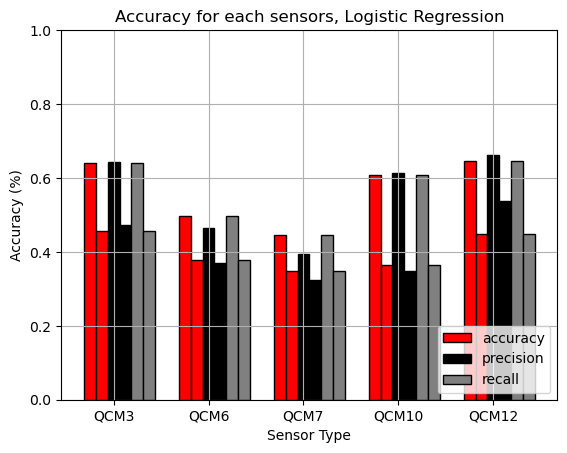

In [15]:
plot_metrics_comp(lg_metrics, model_name='Logistic Regression')

It also obvious from the bar plot above that adding MIP/NP ratio as additional feature resulted in better model overall with higher accuracy, precision, and recall.

## Random Forest

The next one is random forest classifier.

In [16]:
def randomForest_builder():
    return RandomForestClassifier(random_state=42)

metrics_w_ratio = get_metrics_for_model(
    randomForest_builder, include_ratio=True, use_integer_label=False)
metrics_wo_ratio = get_metrics_for_model(
    randomForest_builder, include_ratio=False, use_integer_label=False)
rf_metrics = [metrics_w_ratio, metrics_wo_ratio]

Begin itteration 1
begin training
train acc       -> 100.000%
train precision -> 100.000%
train recall    -> 100.000%

begin testing
finished training session
metrics trials 1: {'accuracy': 0.96, 'precision': 0.9800000000000001, 'recall': 0.96}

Begin itteration 2
begin training
train acc       -> 100.000%
train precision -> 100.000%
train recall    -> 100.000%

begin testing
finished training session
metrics trials 2: {'accuracy': 0.86, 'precision': 0.9, 'recall': 0.86}

Begin itteration 3
begin training
train acc       -> 100.000%
train precision -> 100.000%
train recall    -> 100.000%

begin testing
finished training session
metrics trials 3: {'accuracy': 0.94, 'precision': 0.9818181818181818, 'recall': 0.9400000000000001}

Begin itteration 4
begin training
train acc       -> 100.000%
train precision -> 100.000%
train recall    -> 100.000%

begin testing
finished training session
metrics trials 4: {'accuracy': 0.94, 'precision': 0.9818181818181818, 'recall': 0.9400000000000001}

Beg

In [17]:
show_model_metrics(rf_metrics)

sensor With MIP/NP Ratio                     Without MIP/NP Ratio            \
    type          accuracy precision    recall             accuracy precision   
0   QCM3          0.919048  0.954214  0.919048             0.721905  0.848129   
1   QCM6          0.775238  0.844991  0.775238             0.634286  0.772644   
2   QCM7          0.697143  0.836774  0.697143             0.588571  0.736380   
3  QCM10          0.829524  0.929102  0.829524             0.611429  0.752209   
4  QCM12          0.774286  0.902993  0.774286             0.700000  0.876492   

             
     recall  
0  0.721905  
1  0.634286  
2  0.588571  
3  0.611429  
4  0.700000

The metrics above shows that random forest did much better compare to logistic regression, with average accuracy of 80.3% for model with MIP/NP ratio (as additional feature) and 79.8% accuracy for model without MIP/NP ratio (a little bit worse).

Here, `QCM3` is the best sensor overall for every metrics (accuracy, precision, and recall) and for both features configurations.

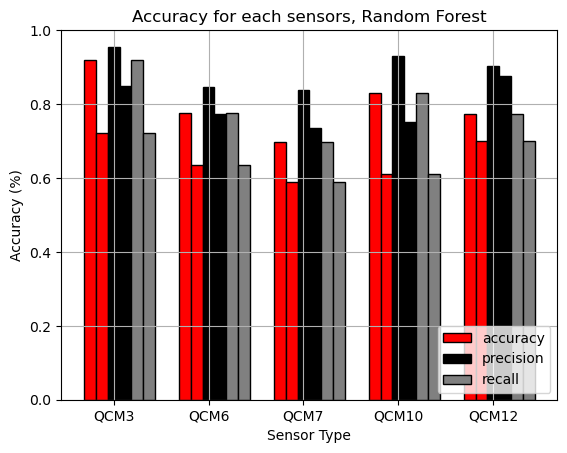

In [18]:
plot_metrics_comp(rf_metrics, model_name='Random Forest')

Same as with logistic model, adding MIP/NP ratio resulted in significant increase in all metrics.

## Gradient Boosting Classifier

The final model is Gradient Boosting Classifier.

In [19]:
def gboost_builder():
    return GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)

metrics_w_ratio = get_metrics_for_model(
    gboost_builder, include_ratio=True, use_integer_label=True)
metrics_wo_ratio = get_metrics_for_model(
    gboost_builder, include_ratio=False, use_integer_label=True)
gboost_metrics = [metrics_w_ratio, metrics_wo_ratio]

Begin itteration 1
begin training
train acc       -> 100.000%
train precision -> 100.000%
train recall    -> 100.000%

begin testing
finished training session
metrics trials 1: {'accuracy': 0.8, 'precision': 0.8400000000000001, 'recall': 0.8}

Begin itteration 2
begin training
train acc       -> 100.000%
train precision -> 100.000%
train recall    -> 100.000%

begin testing
finished training session
metrics trials 2: {'accuracy': 0.92, 'precision': 0.9277777777777778, 'recall': 0.9199999999999999}

Begin itteration 3
begin training
train acc       -> 100.000%
train precision -> 100.000%
train recall    -> 100.000%

begin testing
finished training session
metrics trials 3: {'accuracy': 0.92, 'precision': 0.925, 'recall': 0.9199999999999999}

Begin itteration 4
begin training
train acc       -> 100.000%
train precision -> 100.000%
train recall    -> 100.000%

begin testing
finished training session
metrics trials 4: {'accuracy': 0.96, 'precision': 0.9666666666666668, 'recall': 0.96}

Beg

In [20]:
show_model_metrics(gboost_metrics)

sensor With MIP/NP Ratio                     Without MIP/NP Ratio            \
    type          accuracy precision    recall             accuracy precision   
0   QCM3          0.905714  0.919067  0.905714             0.764762  0.792401   
1   QCM6          0.787619  0.804253  0.787619             0.653333  0.677078   
2   QCM7          0.699048  0.717822  0.699048             0.652381  0.669885   
3  QCM10          0.872381  0.882337  0.872381             0.611429  0.642985   
4  QCM12          0.801905  0.820261  0.801905             0.719048  0.731316   

             
     recall  
0  0.764762  
1  0.653333  
2  0.652381  
3  0.611429  
4  0.719048

The performance of this models (according to above metrics) is very similar with random forest model.

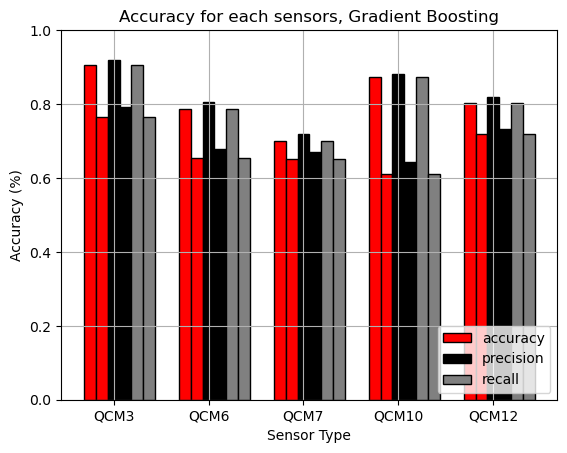

In [21]:
plot_metrics_comp(gboost_metrics, model_name='Gradient Boosting')

## Model Comparison

In [22]:
def plot_model_comparison(lg_metrics: list, rf_metrics: list, gb_metrics: list, 
        model_name='', with_ratio: bool=False):
    width = 0.6

    m_ind = 0 if with_ratio == True else 1
    metrics_lg = lg_metrics[m_ind]
    metrics_rf = rf_metrics[m_ind]
    metrics_gb = gb_metrics[m_ind]

    ind = np.arange(len(metrics_lg['sensor']))*2

    color_dict = {
        'accuracy': 'red',
        'precision': 'black',
        'recall': 'grey',
    }
    figs = []
    metric_names = list(metrics_lg.keys())[1:]
    for i, m in enumerate(metric_names):
        
        fig = plt.bar(ind+i*width, metrics_lg[m], width/3, color=color_dict[m], edgecolor='black')
        fig = plt.bar(ind+i*width+width/3, metrics_rf[m], width/3, color=color_dict[m], edgecolor='black')
        fig = plt.bar(ind+i*width+width/3+width/3, metrics_gb[m], width/3, color=color_dict[m], edgecolor='black')
        figs.append(fig)

    plt.legend(figs, metric_names, loc='lower right')

    plt.xticks(ind+width/2, metrics_lg['sensor'])
    plt.xlabel('Sensor Type')
    plt.ylabel('(%)')

    plt.ylim(0, 1)
    plt.title(', '.join(['Accuracy, precision, and recall for each sensors', model_name]))

    plt.grid()
    plt.gcf().set_figwidth(15)
    plt.show()

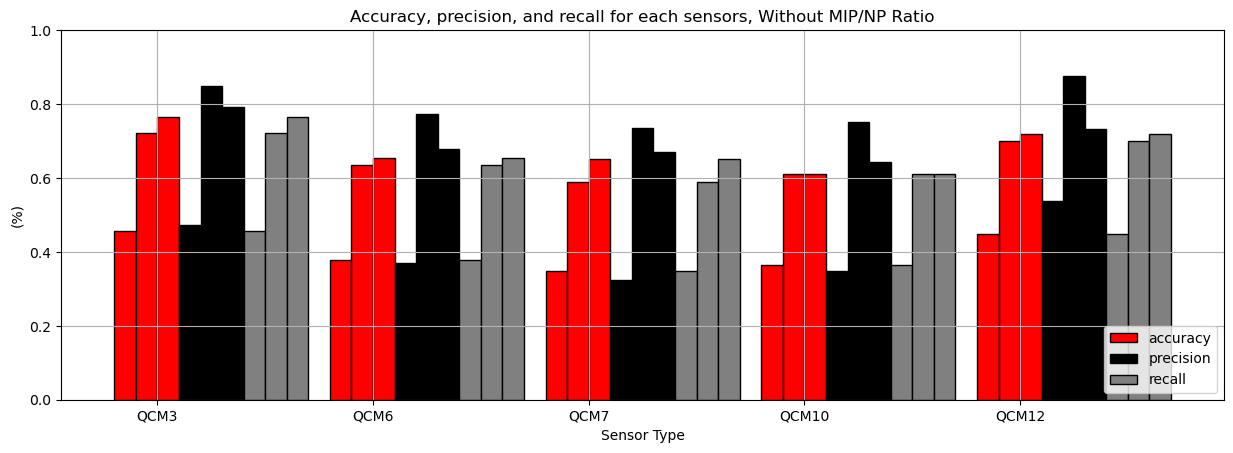

In [23]:
plot_model_comparison(lg_metrics, rf_metrics, gboost_metrics, with_ratio=False, model_name='Without MIP/NP Ratio')

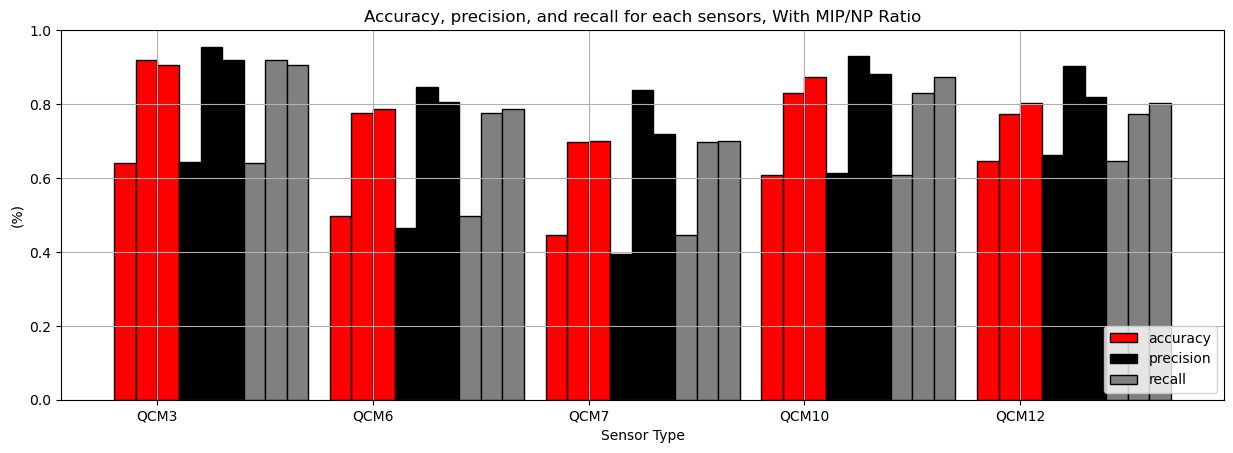

In [24]:
plot_model_comparison(lg_metrics, rf_metrics, gboost_metrics, with_ratio=True, model_name='With MIP/NP Ratio')

From both graphs above we can conclude that the best sensor is `QCM3` paired with random forest model _with_ `MIP/NP ratio` as feature with the following metrics:

In [25]:
m = 0
for key in rf_metrics[0].keys():
    if key == 'sensor':
        print (f'{key.capitalize():<10}   : {rf_metrics[m][key][0]:>6}')
        continue    
    print (f'{key.capitalize():<10}   : {100*rf_metrics[m][key][0]:5.2f}%')

Sensor       :   QCM3
Accuracy     : 91.90%
Precision    : 95.42%
Recall       : 91.90%
